### Alpha Competition Fall 2024

Team: Alex Zhou, Rohit Chintala

Summary: We implement several strategies, and choose the **Internal Bar Strength (IBS) Mean Reversion** strategy (the last Python class of this notebook) for our final submission.

Acknowledgment: The team members had a great time working on this project and would like to thank the organizers of the competition. We also thank the club members who contributed to the infrastructure (without which this work would be impossible), and to the lecturers who inspired our work.

In [ ]:
from sif.siftools.backtesters import full_backtesters as fb
from sif.sifinsights.alpha_search import apply_metric_func
from sif.siftools import operators as op
from sif.siftools import metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (15, 9)

#### Setting the stage

Our backtester covers the period from January 1, 2010, to December 31, 2015.  The portfolio is rebalanced monthly. At each rebalance date, we  use a 37-month rolling window to generate trading signals.

In [ ]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2015, 12, 31)

In [ ]:
fb.FullMultipleBacktester(
    start_date,
    end_date,
    universe_rebalance_dates = [(1,1), (2,1), (3,1), (4,1), (5,1), (6,1), (7,1), (8,1), (9,1), (10,1), (11,1), (12,1)],
    max_lookback = 21 * 37,
    universe_size = 500,
    factors=['close', 'marketcap','pb','high','low']
).save_local('ff_data.npy')

In [ ]:
backtester = fb.FullMultipleBacktester.from_local('ff_data.npy')

#### Baseline Portfolio

As a baseline portfolio, we choose one consisting of uniformly weighted stocks.

In [ ]:
class Uniform(AbstractAlpha):
    def __init__(self):
        self.name = 'Uniform'
        self.lookback = 21 * 37
        self.factor_list = ['close', 'marketcap', 'pb']
        self.universe_size = 500

    def generate_day(self, day, data):

        factors = np.ones(self.universe_size)

        return factors/sum(factors)

#### Residual Momentum

We now implement the residual momentum strategy. According to the Fama-French three-factor model, the return of a stock $i$ (in excess of the risk-free rate) is explained by the formula:

\begin{equation*}
R_i(t) = \alpha_i + \beta_{1,i}\text{MKT}(t) + \beta_{2,i}\text{SMB}(t) + \beta_{3,i}\text{HML}(t) + \varepsilon_i(t)
\end{equation*}

At a given time $t$, $\text{MKT}(t)$ represents the excess return of the market portfolio, $\text{SMB}(t)$ is the excess return of the Small minus Big (by market capitalization) portfolio, and $\text{HML}(t)$ is the excess return of the High minus Low (by book-to-market) portfolio. The coefficients $\beta_{1,i}, \beta_{2,i}, \beta_{3,i}$ are determined by a time series regression.

The residual momentum strategy is as follows: At each rebalance date, we use a 36-month rolling window of data (excluding the current month). The last 12 months of this window are called the formation period. For each stock, we run a regression over the 36-month period to estimate the coefficients $\beta_{1,i}, \beta_{2,i}, \beta_{3,i}$. Then, for each month in the 12-month formation period, we compute the residuals:
\begin{equation*}
\varepsilon_i(t) = R_i(t) - \beta_{1,i}\text{MKT}(t) - \beta_{2,i}\text{SMB}(t) - \beta_{3,i}\text{HML}(t)
\end{equation*}
These residuals roughly capture the $\alpha_i$'s. We then compute the mean and the sample standard deviation of the residuals
\begin{align*}
&\varepsilon_{i}^{\text{mean}} = \frac{1}{12}\sum_{t = 1}^{12}\varepsilon_i(t)\\
&\widetilde{\sigma_{i}}^{2} = \frac{1}{11}\sum_{t = 1}^{12}(\varepsilon_i(t) - \varepsilon_{i}^{\text{mean}})^2
\end{align*}
Using these, we calculate the risk-adjusted residual returns
\begin{equation*}
    \widetilde{{R}_{i}}^{\text{risk adj}} = \frac{\varepsilon_{i}^{\text{mean}}}{\widetilde{\sigma_{i}}}
\end{equation*}
For a given stock $i$, its risk-adjusted residual returns will be higher if it has a larger value of $\alpha_i$ with lower variance over the 36-month period. Finally, we rank the stocks based on their risk-adjusted residual returns long the top decile with the highest risk-adjusted returns. (A long/short strategy, which shorts the stocks in the bottom decile, can also be applied, but it tends to underperform compared to the long-only strategy.)

#### Constructing the Fama-French factors

Instead of following Fama-French's original approach to constructing the three factors, we will use a less intricate but still robust set of methodologies (for simplicity). In particular,

1. We define our baseline as the market portfolio. In future work, this could be replaced with a more appropriate benchmark, such as the S&P 500.  

2. For the SMB (small minus big) factor, we form two portfolios (rather than 6): small companies and big companies. At any given time, "small" companies with the 20% lowest market cap, while "big" companies are those with the 20% highest market cap.  

3. For the HML (high minus low) factor, we form four portfolios: small value, small growth, big value, and big growth. Small and big companies are determined by market capitalization, as described above; value and growth are based on whether a company has the 20% highest or 20% lowest BP/MC = book-to-price/market caps ratio.

In [ ]:
def SMB(self, mkt_caps, ret):
    """ Compute the SMB factor in the Fama-French model

        Args:
            mkt_caps: A self.lookback * self.universe_size array that records the daily market caps.
            ret: A self.lookback * self.universe_size array that records the daily returns.

        Returns:
            the daily SMB factor as an array of size (self.lookback, ).

    """
    percentile = 0.2
    size = int(self.universe_size * percentile)

    # For each row (day), sort the column (stock) indices based on market caps, and select the indices for small and big companies
    sorted_ind = np.argsort(mkt_caps, axis = 1)
    small = sorted_ind[:,:size]
    big= sorted_ind[:, -size:]

    # For each row (day), compute the average returns of small and large companies, and then calculate the SMB factor
    small_ret = op.mean(np.take_along_axis(ret, small, axis = 1), axis = 1)
    big_ret = op.mean(np.take_along_axis(ret, big, axis = 1), axis = 1)
    smb = 1/3 * small_ret - 1/3 * big_ret

    return smb

In [ ]:
def HML(self, mkt_caps, bp, ret):
    """ Compute the HML factor in the Fama-French model

        Args:
            mkt_caps: A self.lookback * self.universe_size array that records the daily market caps.
            bp:  A self.lookback * self.universe_size array that records the daily bp ratios.
            ret: A self.lookback * self.universe_size array that records the daily returns.

        Returns:
            the daily HML factor as an array of size (self.lookback, ).
    """

    percentile = 0.2
    size = int(self.universe_size * percentile)

    # Compute the BP/MC ratio
    bpmc = bp/mkt_caps

    # For each row (month), sort the column (stock) indices based on market caps and BP ratio
    mc_sorted = np.argsort(mkt_caps, axis = 1)
    bpmc_sorted = np.argsort(bpmc, axis = 1)

    # For each row (month), select the indices for big and small companies, as well as for growth and value companies
    small_big = np.hstack((mc_sorted[:, :size], mc_sorted[:, -size:]))
    growth = bpmc_sorted[:, :size]
    value = bpmc_sorted[:, -size:]

    # For each row, take the intersection of column indices, so that:
    # value companies include small and big value companies; growth companies include small and big growth companies.
    value = np.array([np.intersect1d(row1, row2)[0] for (row1, row2) in zip(small_big, value)]).reshape(self.lookback, 1)
    growth = np.array([np.intersect1d(row1, row2)[0] for (row1, row2) in zip(small_big, growth)]).reshape(self.lookback, 1)

    # Compute the monthly average returns of the corresponding groups
    value_ret = op.mean(np.take_along_axis(ret, value, axis = 1), axis = 1)
    growth_ret = op.mean(np.take_along_axis(ret, growth, axis = 1), axis = 1)

    hml = 0.5 * value_ret - 0.5 * growth_ret

    return hml

#### Time Series Regression

We now implement the time series regression that is applied to the 36-month rolling window. Note that the regression is performed on daily data, meaning that with each rebalancing date, 21 new data points are added.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def SerialRegression(ret, mkt_ret, smb, hml):

    """ Run a times series regression of monthly average return over market return, SMB and HML

        Args:
            ret: A self.lookback * self.universe_size array which records monthly average return of each stock in our universe
            mkt_ret: The daily average return of the market portfolio. Array of size (self.lookback, )
            smb: The daily SMB factor in the Fama-French model. Array of size (self.lookback, )
            hml: The daily HML factor in the Fama-French model. Array of size (self.lookback, )

        Returns:
            The residuals (errors + alphas) of the fitted linear regression. Array of size (self.lookback, self.universe_size).
        """
    # Construct a self.lookback * 3 matrix of monthly Fama-French factors.
    factors_matrix = np.array([mkt_ret, smb, hml]).T

    # Provide the traning data, skipping the current month
    X_train = factors_matrix[:-21,:]
    y_train = ret[:-21,:]

    # Run the linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Construct a 3 * (self.universe_size) matrix consisting of regression coefficents of the Fama-French model.
    # The i-th column records the coefficients for stock i
    coeff_matrix = model.coef_.T

    # Compute the residuals (omitting the alphas) as a self.lookbaclk * self.universe_size matrix
    residuals = ret - np.dot(factors_matrix, coeff_matrix)

    return residuals

#### Implementing the strategy

In [ ]:
class ResidualMomentum(AbstractAlpha):
    def __init__(self):
        self.name = 'ResidualMomentum'
        self.lookback = 21 * 37
        self.factor_list = ['close', 'marketcap', 'pb']
        self.universe_size = 500

    def generate_day(self, day, data):

        # Compute/extract daily returns, market caps, and BP ratios
        ret = op.ret(data['close'])[1:,:]
        mkt_caps = data['marketcap'][1:,:]
        bp = 1/data['pb'][1:,:]

        # Construct the Fama-French factors (assuming the market portfolio consists of stocks with uniform weights).
        mkt_ret = op.mean(ret, axis = 1)
        smb = SMB(self, mkt_caps, ret)
        hml = HML(self, mkt_caps, bp, ret)

        # Run the time series regression and compute the residuals
        # Compute the mean and the sample standard deviation of the residuals for the 12 month formation period (skipping the current month)
        residuals = SerialRegression(ret, mkt_ret, smb, hml)
        res_mean = op.mean(residuals[-13 * 21:-21,:], axis = 0)
        res_std = np.std(residuals[-13 * 21:-21,:], axis = 0, ddof = 1)

        # Replace 0's with small positive values
        res_std = np.where(res_std == 0, 0.001, res_std)

        # Compute the risk-adjusted residual returns
        adj_ret = res_mean/res_std

        # Rank the stocks based on adj_ret; long stocks in the top decile
        rank_ind = adj_ret.argsort()
        long = rank_ind[int(-0.1 * self.universe_size):]

        factor = np.zeros(self.universe_size)
        factor[long] = 1/len(long)

        return factor

#### Comparison with other strategies

We compare the residual momentum strategy with several other strategies, including the market portfolio (comprising stocks with equal weights), a portfolio that goes long on stocks in the top decile by market capitalization, and an ETF constructed based on IBS mean reversion.

In [ ]:
class MarketCaps(AbstractAlpha):
    def __init__(self):
        self.name = 'MarketCaps'
        self.lookback = 21 * 37
        self.factor_list = ['close', 'marketcap', 'pb']
        self.universe_size = 500

    def generate_day(self, day, data):

       mkt_caps = data['marketcap'][day]

       percentile = 0.1
       size = int(self.universe_size * percentile)

       # Rank the stocks based on market caps; long the top decile
       ind = mkt_caps.argsort()
       long = ind[-size:]

       factors = np.zeros(self.universe_size)
       factors[long] = 1/len(long)

       return factors

In [ ]:
class MeanReversion(AbstractAlpha):
    def __init__(self):
        self.name = 'MeanReversion'
        self.lookback = 21 * 37
        self.factor_list = ['close', 'high', 'low']
        self.universe_size = 500

    def generate_day(self, day, data):
        P_C = data['close'][day]
        P_L = data['low'][day]
        P_H = data['high'][day]
        data['IBS'] = (P_C - P_L)/(P_H - P_L)
        IBS = pd.Series(data['IBS'])
        sorted_IBS = IBS.sort_values(ascending=False)
        top_decile = sorted_IBS.quantile(0.998)
        bottom_decile = sorted_IBS.quantile(0.002)
        weights = np.zeros(500)
        weights[IBS >= top_decile] = -1
        #weights[IBS <= bottom_decile] = 1
        return op.weight(weights)

The following block takes roughly 5 minutes to run.

Uniform:   0%|          | 0/4 [00:00<?, ?it/s]

MeanReversion:  75%|███████▌  | 3/4 [03:33<01:08, 68.38s/it]    /tmp/ipykernel_243327/1297201535.py:12: RuntimeWarning: invalid value encountered in true_divide
  data['IBS'] = (P_C - P_L)/(P_H - P_L)
MeanReversion: 100%|██████████| 4/4 [03:41<00:00, 55.48s/it]


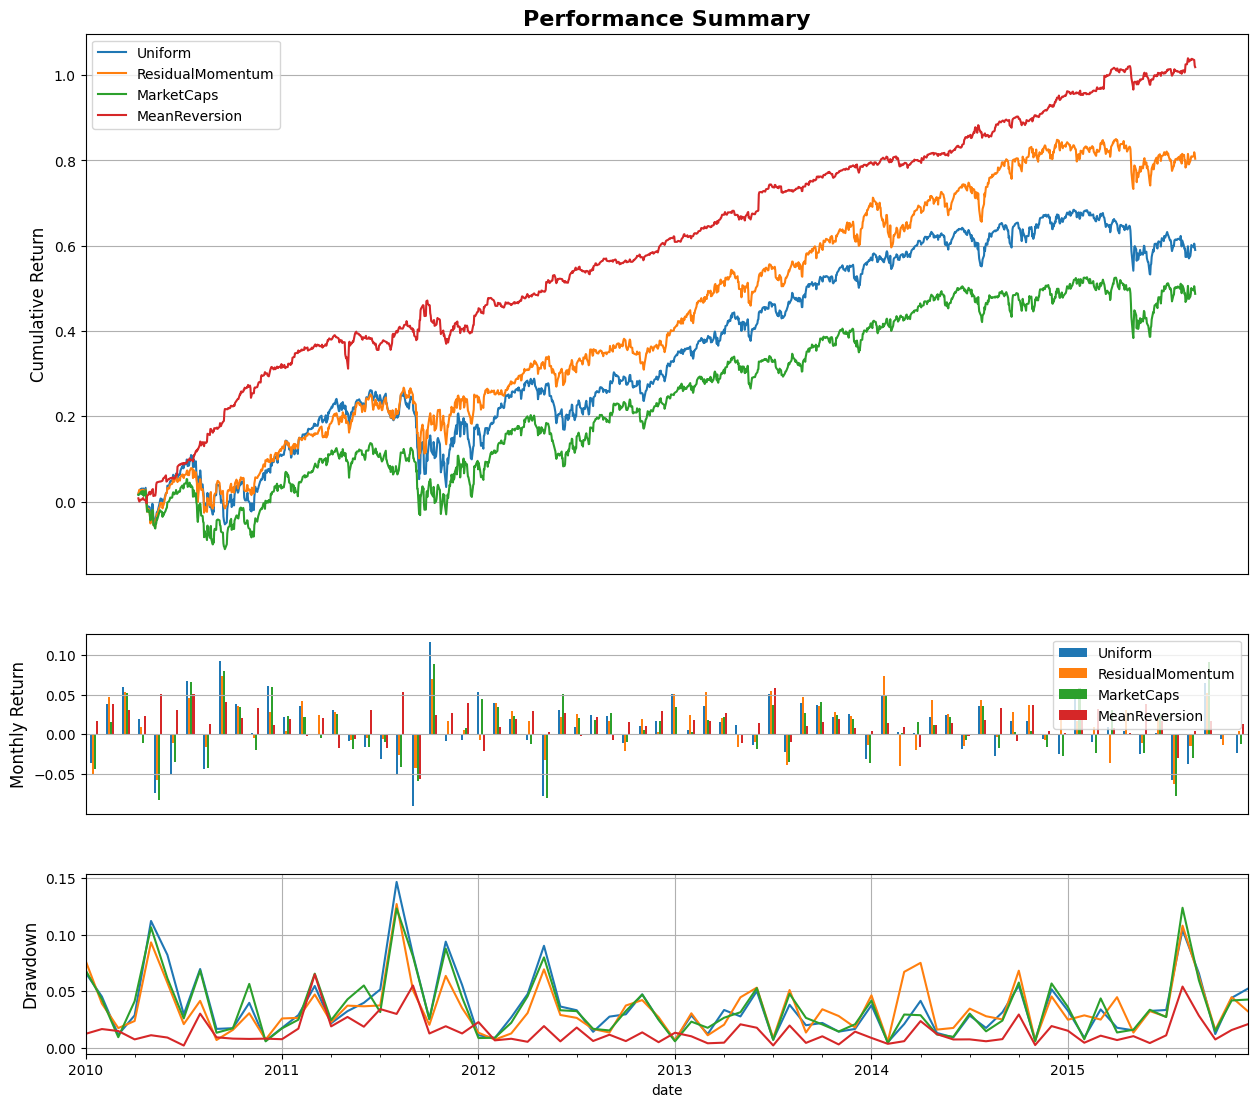

In [ ]:
alphas = [Uniform(), ResidualMomentum(), MarketCaps(), MeanReversion()]

returns, holdings = backtester.backtest(alphas, processes= None)
metrics.summary_plot(returns, source=['Uniform','ResidualMomentum','MarketCaps','MeanReversion'])

As we can see, the IBS Mean Reversion strategy (a short-only strategy) performs the best among all strategies. However, the residual momentum strategy performs better than the market portfolio, suggesting its robustness. For future work, we could replace the market portfolio in the Fama-French model with the S&P 500 or the IBS Mean Reversion portfolio, and check the whether the residual momentum strategy outperforms these two portfolios as well.